<h1><center><b>Document Similarity</b></center></h1>

---

# Introduction

Exploring Document Similarity in NLP. Computing document similarity involves comparing two documents and assigning a score that indicates the degree of similarity between two documents.

Some key use cases of document similarity are:

1. Document clustering
2. Topic modelling
3. Recommendation systems
4. Analyzing social media trends

This project explores text preprocessing methods, document similarity algorithms, and pre-trained models.

- Part 1 sets up the environment through installation of the required dependencies and incorporates a kernel restart once the installation finishes.
- Part 2 downloads and explores the dataset.
- Part 3 builds text preprocessing methods.
- Part 4 finds document similarity using similarity measures. Jaccard Similarity, Cosine distance with Word vectors will be explored here.
- Part 5 implements tf-idf vectorization and BERT embeddings to calculate document similarity.
- Part 6 concludes with ideas for further study.
- Part 7 provides instructions for uploading responses and information about grading.


# Part 1: Setting up the environment


## Install dependencies

The en_core_web_md module is used for:

1. en: English
2. core: Vocabulary, syntax, entities
3. web: Written text - (blogs, news, comments)
4. md: 31 MB (This project uses the medium version [here](https://spacy.io/models/en#en_core_web_lg) for quick and reliable analysis; but feel free to try out other versions, below.)

Other versions:

1. Small: [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm)
2. Large: [en_core_web_lg](https://spacy.io/models/en#en_core_web_lg)
3. Transformer: [en_core_web_trf](https://spacy.io/models/en#en_core_web_trf)

**Run the code cell below to install required dependencies.**

> After installation, you may need to restart the kernel.


In [ ]:
%pip install datasets
%pip install --upgrade spacy==3.2
%pip install transformers
%pip install sentence-transformers
!python -m spacy download en_core_web_md

from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

# Part 2 - Downloading and sampling the dataset

Download and sample the dataset **[AG's corpus of news articles](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html)** which is a collection of more than 1 Million News Articles, extracted from more than 2000 news resources within a span of one year, labeled with 4 news categories: 0. World

1. Sports
2. Business
3. Sci/Tech


## Download the Dataset


In [4]:
import pandas as pd

from datasets import load_dataset

dataset = load_dataset("ag_news")
train = dataset.get("train").to_pandas().rename(columns={"label": "category"})
test = dataset.get("test").to_pandas().rename(columns={"label": "category"})

/Users/krishnakodali/Documents/university-of-florida/academics/sem-2/NLP/projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sample the dataset


In [5]:
train = train.sample(frac=0.001, random_state=1).reset_index(drop=True)
test = test.sample(frac=0.01, random_state=1).reset_index(drop=True)

# Part 3 - Text preprocessing

To reduce noise in the data, text preprocessing is performed using the following preprocessing methods:

1. Tokenization
2. Punctuation removal
3. Stop word removal
4. Word lemmatization


## Tokenization


In [6]:
import spacy
import string

from typing import List

from spacy.tokens.token import Token

nlp = spacy.load("en_core_web_md")
sample_text = "These are a series of demos, to show how& to use spacy **for** preprocessing tasks!"

In [7]:
def tokenize(text: str) -> List[Token]:
    doc = nlp(text)
    return [word for word in doc]


print("Tokenizer output: ", tokenize(sample_text))
print("Split output: ", sample_text.split(" "))

Tokenizer output:  [These, are, a, series, of, demos, ,, to, show, how, &, to, use, spacy, *, *, for, *, *, preprocessing, tasks, !]
Split output:  ['These', 'are', 'a', 'series', 'of', 'demos,', 'to', 'show', 'how&', 'to', 'use', 'spacy', '**for**', 'preprocessing', 'tasks!']


In [8]:
tokens = tokenize(sample_text)

## Punctuation and stopword removal.


In [9]:
def remove_punctuation(tokens: List[Token]) -> List[Token]:
    return [t for t in tokens if t.text not in string.punctuation]


def remove_stop_words(tokens: List[Token]) -> List[Token]:
    return [t for t in tokens if not t.is_stop]

## Text Lemmatization


In [11]:
def lemmatize(tokens: List[Token]) -> List[str]:
    return [token.lemma_ for token in tokens]

# Part 4 - Similarity Algorithms

Few well known techniques are used to determine how similar two documents are. Then, these similarity measures are used to find the most similar document in the training dataset to any given document.


## Jaccard Similarity

Jaccard similarity is a statistical measure to gauge similarity and diversity among different sets. In NLP applications, Jaccard similarity has been applied to determine:

1. Character-level similarity
2. Word-level similarity
3. Sentence-level similarity

In general, character-based similarity is less meaningful, as character counts are not necessarily indicative of linguistic structure or meaning. By contrast, applying Jaccard at the word or sentence level supports similarity detection where meaningful units (words, sentences) are repeatedly used in the data set, as in social media texts.

The task of topic modeling is considered, where a _word-level similarity_ comparison is made over the words as tokens, as extracted from text documents. A comparison is made for _n_-grams where _n_ is the number of adjacent tokens considered per comparison. By default, 1-gram n-grams are used for comparisons.

Start with Jaccard similarity as a token (word)-based method to perform document similarity. Divide the magnitude of intersection of different tokens (words) among two documents, by the magnitude of the union.

Formally,  
A = tokens of document1  
B = tokens of document2

Jaccard Similarity = $\frac{|A \cap  B|}{|A \cup B|}$

Note: In Jaccard Similarity we compare the actual tokens in the document and not their meaning in any way; although this limits the accuracy of this comparison algorithm, it is a first step toward understanding the notion of _semantic similarity_.


### Preprocessing for Jaccard Similarity


In [13]:
def preprocess_text_jaccard(text) -> List[str]:
    """
    This function expects an object of type string and returns a list of lemmas
    after removing puctuations and stop words
    """
    tokens = tokenize(text)
    tokens = remove_punctuation(tokens)
    tokens = remove_stop_words(tokens)
    tokens = lemmatize(tokens)

    return tokens


tokens = preprocess_text_jaccard(sample_text)
print(tokens)

['series', 'demos', 'use', 'spacy', 'preprocessing', 'task']


**Execute the code below to apply the preprocessing on the entire train and test samples (this step could take up to 5 minutes), and then execute the print command.**


In [14]:
train["text_processed"] = train["text"].apply(preprocess_text_jaccard)
test["text_processed"] = test["text"].apply(preprocess_text_jaccard)
print(train["text_processed"].head())

0    [BEA, buzz, Beehive, BURLINGAME, CALIF.--, BEA...
1    [Saudi, violence, push, Oil, Prices, high, oil...
2    [storm, show, Haiti, 39;s, strait, muddy, wate...
3    [crew, fail, find, tree, Killing, Beetle, AP, ...
4    [justice, Light, bad, Stern, stop, 30, game, R...
Name: text_processed, dtype: object


In [ ]:
from typing import List


def jaccard_similarity(source: List[str], target: List[str]) -> float:
    """
    This function accepts two list of str and calculates Jaccard Similarity
    """

    intersection = set(source) & set(target)
    union = set(source) | set(target)
    if not union:
        return 0.0
    return len(intersection) / len(union)

In [23]:
try:
    assert (
        jaccard_similarity(
            preprocess_text_jaccard("This is a passage about oil"),
            preprocess_text_jaccard("This is another passage about oil"),
        )
        > 0.9
    )
    assert (
        jaccard_similarity(
            preprocess_text_jaccard("these are"),
            preprocess_text_jaccard("completely different"),
        )
        == 0
    )
    assert (
        jaccard_similarity(
            preprocess_text_jaccard("petrol prices are high"),
            preprocess_text_jaccard("petrol prices are very low"),
        )
        == 0.5
    )
    print("Test Passed!")
except AssertionError as e:
    print("Test Failed")
    raise

Test Passed!


### Applying Jaccard Similarity to the corpus


In [24]:
def find_most_similar_document_jaccard(test_data_point: List[str]) -> int:
    """
    This functions finds the most similar document to the test_data_point
    using the Jaccard distance metric
    """

    train["similarity_score"] = train["text_processed"].apply(
        lambda x: jaccard_similarity(x, test_data_point)
    )
    return train["similarity_score"].idxmax()

We test the Jaccard Similarity function on one of the documents from the test set to obtain the most similar document. **Change the document number in the first line of code below to test for other documents.**


In [25]:
document1 = test.iloc[2]
print(f"Test Document \n{document1.text}\n")
most_similar = find_most_similar_document_jaccard(document1["text_processed"])
print(f"Most Similar Document \n{train.iloc[most_similar].text}")

Test Document 
Techs extend Nikkei #39;s rally Technology shares edged up in Asia on Tuesday, as crude oil prices hovered near \$44 a barrel and the dollar languished ahead of key US economic data.

Most Similar Document 
US election reprieve for oil NEW YORK: Oil dropped below \$50 a barrel last night to the lowest price in more than a month, extending a \$6 slide from recent peaks as the US presidential election got underway.


### Jaccard Evaluation

One way to evaluate the accuracy of similarity models is to determine whether the category of the most similar document matches that of the source document. If both are labeled with the same category, the two documents are considered to be "similar".

Let's return to our news categorization example:

1. World
2. Sports
3. Business
4. Sci/Tech

A _confusion matrix_ is a table that is used to investigate the performance of a classification algorithm. A confusion matrix visualizes and summarizes the performance of a classification algorithm, that is, it illustrates for each predicted outcome whether the system output is correct.

A _heatmap_ can be used to visualize the outcome of a classification solution. Each row in the heatmap is a predicted category for a given document and each column is the actual category for that document. This form of visualization allows one to decide which categories are best characterized by the classification algorithm. The heatmap below employs darker colors for higher values and lighter colors for lower values. Note that the number of **false negatives** for a given category X is the sum of the values in row X (excluding the value in column X) and the number of **false positives** for a given category X is the sum of the values in column X (excluding the value in row X).


   precision    recall    fscore
0   0.750000  0.631579  0.685714
1   0.565217  0.619048  0.590909
2   0.714286  0.714286  0.714286
3   0.437500  0.466667  0.451613


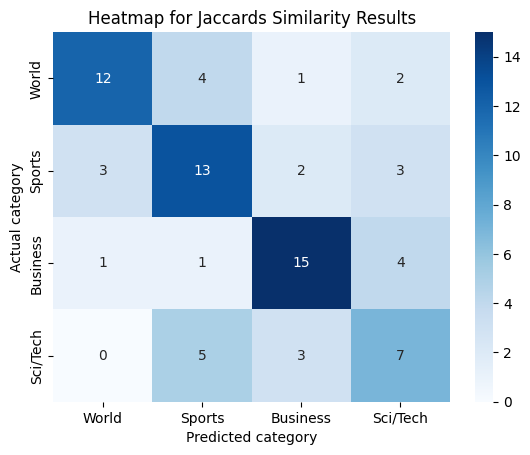

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

category_found = train["category"].iloc[
    test["text_processed"].apply(lambda x: find_most_similar_document_jaccard(x))
]
category_found = category_found.reset_index()
test["category_found"] = category_found["category"]

precision, recall, fscore, support = precision_recall_fscore_support(
    test["category"], test["category_found"]
)
print(pd.DataFrame({"precision": precision, "recall": recall, "fscore": fscore}))

cf_matrix = confusion_matrix(test["category"], test["category_found"])
ax = plt.axes()
sns.heatmap(
    cf_matrix,
    annot=True,
    xticklabels=["World", "Sports", "Business", "Sci/Tech"],
    yticklabels=["World", "Sports", "Business", "Sci/Tech"],
    cmap="Blues",
    ax=ax,
)
ax.set_title("Heatmap for Jaccards Similarity Results")
ax.set_xlabel("Predicted category")
ax.set_ylabel("Actual category")
plt.show()

## 3.2 Cosine Distance

Cosine similarity is a measure of similarity between two sequences of numbers. The sequences are viewed as vectors in an inner product space, and the cosine similarity is defined as the cosine of the angle between them, that is, the dot product of the vectors divided by the product of their lengths. It follows that the cosine similarity does not depend on the magnitudes of the vectors, but only on their angle.

### Word Vectors

Word embeddings (also called word vectors) represent each word numerically in such a way that the vector corresponds to how that word is used or what it means. Vector encodings are learned by considering the context in which the words appear. Words that appear in similar contexts will have similar vectors.

Word vectors (Word2vec) can be used as features for machine learning models. Word vectors will typically improve the performance of models above bag of words encoding.

Here pretrained word vectorizer will be imported and look up the vector representation of the words from it. An average vector representation of a document is calculated by a mean of word vectors.

A = Average vector representation of document1
B = Average vector representation of document2

Cosine Distance = $1- \frac{A.B}{\mid A\mid \mid B\mid}$


### Preprocessing for Cosine Similarity


In [30]:
import numpy as np


def preprocess_cosine_similarity(text: str) -> np.array:
    tokens = tokenize(text)
    tokens = remove_punctuation(tokens)
    tokens = remove_stop_words(tokens)
    vector = np.mean([word.vector for word in tokens], axis=0)
    return vector


print(f"Vector representation of '{sample_text}'")
print(preprocess_cosine_similarity(sample_text)[:10])

Vector representation of 'These are a series of demos, to show how& to use spacy **for** preprocessing tasks!'
[-0.76228005  0.21994667  0.03597595 -0.03389915 -0.32809135  0.19858451
  0.21446133 -0.15553208  0.16237001  0.880155  ]


### Applying Cosine Similarity to the corpus


In [31]:
train["text_processed"] = train["text"].apply(preprocess_cosine_similarity)
test["text_processed"] = test["text"].apply(preprocess_cosine_similarity)

In [34]:
from scipy.spatial.distance import cosine


def cosine_similarity(vector_1: np.array, vector_2: np.array) -> float:
    """
    :param vector_1: vector of the first document
    :param vector_2: vector of the second document
    :return: cosine similarity between the two documents
    """
    if np.all(vector_1 == 0) or np.all(vector_2 == 0):
        return 0.0
    return 1 - cosine(vector_1, vector_2)

In [35]:
try:
    assert cosine_similarity(np.zeros(5), np.zeros(5)) == 0
    assert cosine_similarity(np.zeros(5), np.ones(5)) == 0
    assert cosine_similarity(np.array([2, 3, 4]), np.array([2, 3, 4])) == 1.0
    print("Test Passed!")
except AssertionError as e:
    print("Test Failed")
    raise

Test Passed!


In [38]:
def find_most_similar_document_cosine(test_data_point: np.array) -> int:
    """
    This function finds the most similar document to the test_data_point
    using the cosine distance metric
    """

    train["similarity_score"] = train["text_processed"].apply(
        lambda x: cosine_similarity(x, test_data_point)
    )
    return train["similarity_score"].idxmax()

In [39]:
document1 = test.iloc[2]
print(f"Test Document \n{document1.text}\n")
most_similar = find_most_similar_document_cosine(document1["text_processed"])
print(f"Most Similar Document \n{train.iloc[most_similar].text}")

Test Document 
Techs extend Nikkei #39;s rally Technology shares edged up in Asia on Tuesday, as crude oil prices hovered near \$44 a barrel and the dollar languished ahead of key US economic data.

Most Similar Document 
Nikkei Up 1.5 Pct, Year-End Rally Eyed  TOKYO (Reuters) - Tokyo stocks posted strong rises by  Friday afternoon as hopes for a seasonal year-end rally and the  imminent inclusion of oil and gas developer INPEX Corp. into  the TOPIX index, spurred buying in a wide range of stocks.


### Cosine Distance Evaluation


   precision    recall    fscore
0   0.700000  0.736842  0.717949
1   0.900000  0.857143  0.878049
2   0.653846  0.809524  0.723404
3   0.600000  0.400000  0.480000


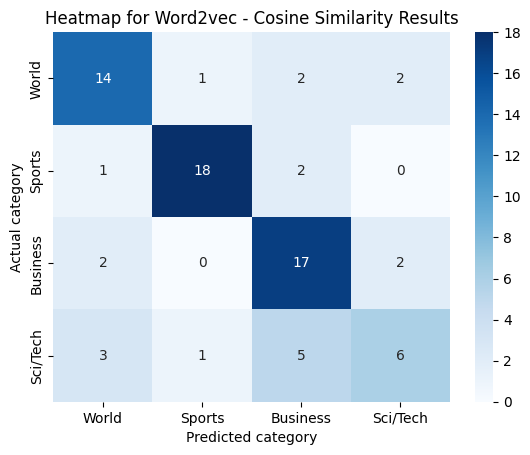

In [40]:
category_found = train["category"].iloc[
    test["text_processed"].apply(lambda x: find_most_similar_document_cosine(x))
]
category_found = category_found.reset_index()
test["category_found"] = category_found["category"]

cf_matrix = confusion_matrix(test["category"], test["category_found"])

precision, recall, fscore, support = precision_recall_fscore_support(
    test["category"], test["category_found"]
)
print(pd.DataFrame({"precision": precision, "recall": recall, "fscore": fscore}))
ax = plt.axes()
sns.heatmap(
    cf_matrix,
    annot=True,
    xticklabels=["World", "Sports", "Business", "Sci/Tech"],
    yticklabels=["World", "Sports", "Business", "Sci/Tech"],
    cmap="Blues",
    ax=ax,
)
ax.set_title("Heatmap for Word2vec - Cosine Similarity Results")
ax.set_xlabel("Predicted category")
ax.set_ylabel("Actual category")
plt.show()

# Part 5 - Vectorization techniques


## TF-IDF

TF-IDF is a very important technique, widely used in practice for its simplicity, performance, and accuracy. It is the same algorithm used by many search engines to index and search text documents, e.g., [Solr](https://solr.apache.org/guide/8_0/term-vectors.html) and [ElasticSearch](https://www.elastic.co/guide/en/elasticsearch/reference/5.6/similarity.html).

TF-IDF weight indicates the importance of a word in a given document by detecting whether a word is discriminative of a particular document or not. In this section, TF-IDF weights are used to convert sentences into vector representations.

The calculation of the TF-IDF weight for a word _t_ in document _d_ is as follows:

$$
\text{TF-IDF}_{t,d} = \text{tf}_{t,d} \cdot \text{idf}_t
$$

where

$$
\text{tf}_{t,d} = \log_{10}(\text{count}(t,d) + 1)
$$

$$
\text{idf}_t = \log_{10} \left( \frac{N}{\text{df}_t} \right)
$$

Here,

- $N$ = total number of documents
- $\text{df}_t$ = number of documents in which word _t_ occurs


In [ ]:
def preprocess_text_tfidf(text: str) -> str:
    """
    This functions accepts a str as input and performs processing for TF-IDF
    """

    tokens = tokenize(text)
    tokens = remove_punctuation(tokens)
    tokens = lemmatize(tokens)

    return " ".join(tokens)

In [60]:
try:
    # test - regular input
    assert (
        preprocess_text_tfidf(
            "testing out the functionality of the tf-idf method, lets see how well it performs"
        )
        == "test out the functionality of the tf idf method lets see how well it perform"
    )

    print("Test Passed!")
except AssertionError as e:
    print("Test Failed")
    raise

Test Passed!


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf_vectorizer(train_sample: pd.DataFrame, test_sample: pd.DataFrame):
    vect = TfidfVectorizer(ngram_range=(1, 2))
    train_sample["text_processed"] = list(
        vect.fit_transform(train_sample["text"].apply(preprocess_text_tfidf)).toarray()
    )
    test_sample["text_processed"] = list(
        vect.transform(test_sample["text"].apply(preprocess_text_tfidf)).toarray()
    )
    return train_sample, test_sample

In [62]:
train, test = get_tfidf_vectorizer(train, test)
document1 = test.iloc[2]
print(f"Test Document \n{document1.text}\n")
most_similar = find_most_similar_document_cosine(document1["text_processed"])
print(f"Most Similar Document \n{train.iloc[most_similar].text}")

Test Document 
Techs extend Nikkei #39;s rally Technology shares edged up in Asia on Tuesday, as crude oil prices hovered near \$44 a barrel and the dollar languished ahead of key US economic data.

Most Similar Document 
Saudi Violence Pushes Oil Prices Higher Oil prices were forced higher today by an outbreak of violence in Saudi Arabia and concerns that Opec may cut output. The cost of a barrel of light, sweet crude oil climbed 


### TF-IDF with cosine distance Evaluation


   precision    recall    fscore
0   0.619048  0.684211  0.650000
1   0.684211  0.619048  0.650000
2   0.666667  0.761905  0.711111
3   0.666667  0.533333  0.592593


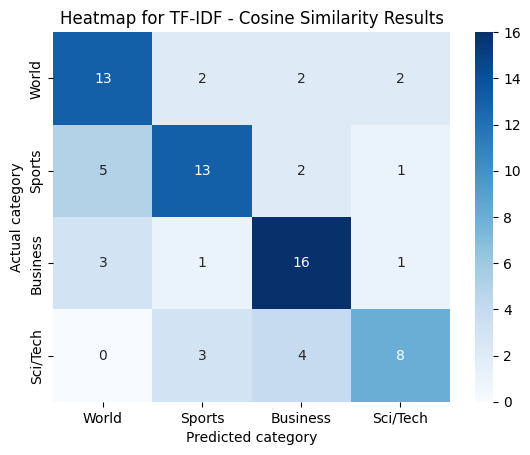

In [64]:
category_found = train["category"].iloc[
    test["text_processed"].apply(lambda x: find_most_similar_document_cosine(x))
]
category_found = category_found.reset_index()
test["category_found"] = category_found["category"]

cf_matrix = confusion_matrix(test["category"], test["category_found"])

precision, recall, fscore, support = precision_recall_fscore_support(
    test["category"], test["category_found"]
)
print(pd.DataFrame({"precision": precision, "recall": recall, "fscore": fscore}))
ax = plt.axes()
sns.heatmap(
    cf_matrix,
    annot=True,
    xticklabels=["World", "Sports", "Business", "Sci/Tech"],
    yticklabels=["World", "Sports", "Business", "Sci/Tech"],
    cmap="Blues",
    ax=ax,
)
ax.set_title("Heatmap for TF-IDF - Cosine Similarity Results")
ax.set_xlabel("Predicted category")
ax.set_ylabel("Actual category")
plt.show()

## BERT Embeddings


**B**idirectional **E**ncoder **R**epresentations from **T**ransformers (BERT) is a deep learning model developed using the Transformer architecture.

As suggested by its name, BERT is a bi-directional encoder that considers both right and left context during training. The model is trained on a large amount of text data to generate contextual word embeddings depending on the context a particular word appears. BERT is pre-trained on two unsupervised learning objectives.

1. Masked Language Modeling (MLM) - Some words in the input sentences are randomly masked so that the model is tasked to predict the masked words based on the context observed.
2. Next Sentence Prediction (NSP) - Here, BERT is trained to predict whether two given sentences are contiguous in the original text.


### Tokenization

In part 3, spacy tokenizer separated a given sentence into words, punctuation marks and special symbols. Therefore, spacy tokenizer can be considered as a word-level tokenizer. But the BERT model utilizes a sub-word tokenizer where a given sentence is separated into smaller sub-word units to handle out-of-vocabulary (OOV) words. Since words can be broken down into more frequently used sub-words, even though the particular word itself is not available in the model vocabulary, there is a high chance for its sub-words to be available, hence making it possible to represent the particular word. An example is shown below.

In the below example the word "cerulean" is broken down to three sub-words, "ce", "##ru" and "##lean" during tokenization, but when token ids are decoded as a whole, these three sub-words are connected together to form the initial word "cerulean".


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

example_text = "I am reading 'The House in the Cerulean Sea'"
bert_input = tokenizer(
    example_text,
    padding="max_length",
    max_length=15,
    truncation=True,
    return_tensors="pt",
)

#  id of each token in the vocabulary
print(bert_input["input_ids"])
print(bert_input["token_type_ids"])
print(bert_input["attention_mask"])


for i in bert_input["input_ids"][0]:
    print(tokenizer.decode(i))

print(tokenizer.decode(bert_input["input_ids"][0]))

tensor([[  101,  1045,  2572,  3752,  1005,  1996,  2160,  1999,  1996,  8292,
          6820, 20898,  2712,  1005,   102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
[CLS]
i
am
reading
'
the
house
in
the
ce
##ru
##lean
sea
'
[SEP]
[CLS] i am reading'the house in the cerulean sea'[SEP]


In [72]:
import torch
import numpy as np

from transformers import BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")


def preprocess_text_bert(text: str) -> np.array:
    """
    This function expects an object of type string and returns a numpy array after
    tokenizing the text through BertTokenizer and generating vectors using BertModel
    """
    bert_input = tokenizer(text, return_tensors="pt")

    with torch.no_grad():
        outputs = model(
            input_ids=bert_input["input_ids"],
            attention_mask=bert_input["attention_mask"],
        )
        vector = torch.mean(outputs.last_hidden_state, dim=1)

    return vector.squeeze().numpy()


print(f"Vector representation of '{sample_text}'")
print(preprocess_text_bert(sample_text)[:10])

Vector representation of 'These are a series of demos, to show how& to use spacy **for** preprocessing tasks!'
[ 0.23657905 -0.02994122  0.38747624  0.04338304  0.2302582  -0.46953556
  0.28012517  0.25555784 -0.16120914  0.02559497]


### Applying Cosine similarity with BERT embeddings to the corpus

This execution will take some time.


In [76]:
train["text_processed"] = train["text"].apply(lambda text: preprocess_text_bert(text))
test["text_processed"] = test["text"].apply(lambda text: preprocess_text_bert(text))

In [77]:
document1 = test.iloc[2]
print(f"Test Document \n{document1.text}\n")
most_similar = find_most_similar_document_cosine(document1["text_processed"])
print(f"Most Similar Document \n{train.iloc[most_similar].text}")

Test Document 
Techs extend Nikkei #39;s rally Technology shares edged up in Asia on Tuesday, as crude oil prices hovered near \$44 a barrel and the dollar languished ahead of key US economic data.

Most Similar Document 
Nikkei Up 1.5 Pct, Year-End Rally Eyed  TOKYO (Reuters) - Tokyo stocks posted strong rises by  Friday afternoon as hopes for a seasonal year-end rally and the  imminent inclusion of oil and gas developer INPEX Corp. into  the TOPIX index, spurred buying in a wide range of stocks.


### Cosine Distance with BERT embeddings Evaluation


   precision    recall    fscore
0   0.800000  0.842105  0.820513
1   1.000000  0.809524  0.894737
2   0.684211  0.619048  0.650000
3   0.500000  0.666667  0.571429


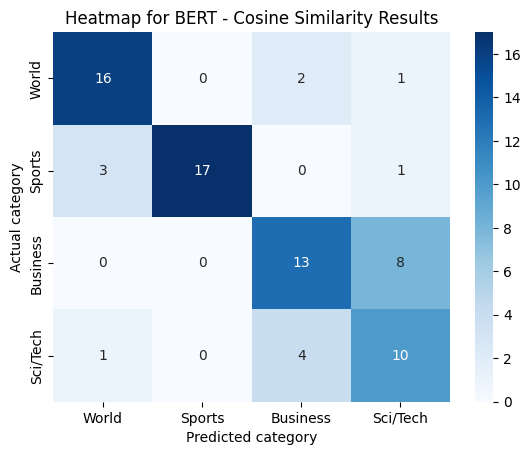

In [78]:
category_found = train["category"].iloc[
    test["text_processed"].apply(lambda x: find_most_similar_document_cosine(x))
]
category_found = category_found.reset_index()
test["category_found"] = category_found["category"]

cf_matrix = confusion_matrix(test["category"], test["category_found"])

precision, recall, fscore, support = precision_recall_fscore_support(
    test["category"], test["category_found"]
)
print(pd.DataFrame({"precision": precision, "recall": recall, "fscore": fscore}))
ax = plt.axes()
sns.heatmap(
    cf_matrix,
    annot=True,
    xticklabels=["World", "Sports", "Business", "Sci/Tech"],
    yticklabels=["World", "Sports", "Business", "Sci/Tech"],
    cmap="Blues",
    ax=ax,
)
ax.set_title("Heatmap for BERT - Cosine Similarity Results")
ax.set_xlabel("Predicted category")
ax.set_ylabel("Actual category")
plt.show()

## SBERT Embeddings


**SBERT**, short for **Sentence-BERT** (https://arxiv.org/pdf/1908.10084.pdf) is a modified architecture of the pre-trained BERT model, incorporating siamese and triplet network architectures to generate semantically meaningful **sentence embeddings**, which can be compared using cosine similarity. Therefore, this model architecture is highly useful in various Natural Language Processing tasks such as Semantic textual similarity calculation, semantic search or paraphrase mining.


In [ ]:
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")


def preprocess_text_sbert(text: str) -> np.array:
    """
    This function expects an object of type string and returns a numpy array after
    tokenizing the text through BertTokenizer and generating vectors using BertModel
    """

    embedding = sbert_model.encode(text)
    return embedding


print(f"Vector representation of '{sample_text}'")
print(preprocess_text_sbert(sample_text)[:10])

Vector representation of 'These are a series of demos, to show how& to use spacy **for** preprocessing tasks!'
[-0.05736241  0.02989369 -0.03810472 -0.04411058 -0.04040003 -0.05502092
  0.01938878 -0.04331468 -0.08909785 -0.007048  ]


### Applying Cosine similarity with SBERT embeddings to the corpus


In [84]:
train["text_processed"] = train["text"].apply(lambda text: preprocess_text_sbert(text))
test["text_processed"] = test["text"].apply(lambda text: preprocess_text_sbert(text))

In [85]:
document1 = test.iloc[2]
print(f"Test Document \n{document1.text}\n")
most_similar = find_most_similar_document_cosine(document1["text_processed"])
print(f"Most Similar Document \n{train.iloc[most_similar].text}")

Test Document 
Techs extend Nikkei #39;s rally Technology shares edged up in Asia on Tuesday, as crude oil prices hovered near \$44 a barrel and the dollar languished ahead of key US economic data.

Most Similar Document 
Nikkei Up 1.5 Pct, Year-End Rally Eyed  TOKYO (Reuters) - Tokyo stocks posted strong rises by  Friday afternoon as hopes for a seasonal year-end rally and the  imminent inclusion of oil and gas developer INPEX Corp. into  the TOPIX index, spurred buying in a wide range of stocks.


### Cosine Distance with SBERT embeddings Evaluation

   precision    recall    fscore
0   0.772727  0.894737  0.829268
1   1.000000  0.904762  0.950000
2   0.818182  0.857143  0.837209
3   0.846154  0.733333  0.785714


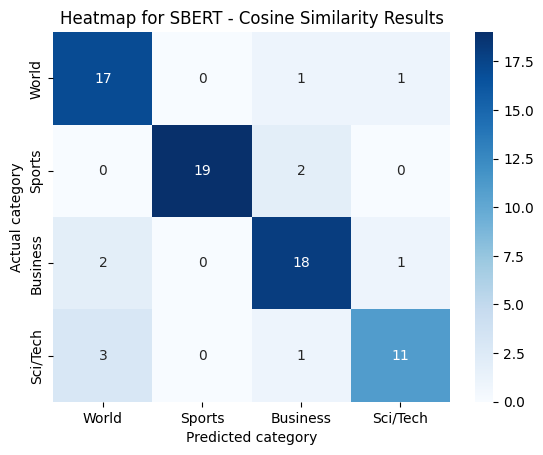

In [86]:
category_found = train["category"].iloc[
    test["text_processed"].apply(lambda x: find_most_similar_document_cosine(x))
]
category_found = category_found.reset_index()
test["category_found"] = category_found["category"]

cf_matrix = confusion_matrix(test["category"], test["category_found"])

precision, recall, fscore, support = precision_recall_fscore_support(
    test["category"], test["category_found"]
)
print(pd.DataFrame({"precision": precision, "recall": recall, "fscore": fscore}))
ax = plt.axes()
sns.heatmap(
    cf_matrix,
    annot=True,
    xticklabels=["World", "Sports", "Business", "Sci/Tech"],
    yticklabels=["World", "Sports", "Business", "Sci/Tech"],
    cmap="Blues",
    ax=ax,
)
ax.set_title("Heatmap for SBERT - Cosine Similarity Results")
ax.set_xlabel("Predicted category")
ax.set_ylabel("Actual category")
plt.show()